# Training the model
This part is based on the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## Import libraries




In [8]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
import random
from natsort import natsorted
from glob import glob

from matplotlib import pyplot as plt
from IPython import display

In [10]:
#dataset

import zipfile

#path to zip of dataset
zip_file = "./Data/Dataset.zip"
extract_dir = './Data/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

#Path to unzipped dataset
PATH = "./Data/Data"

# paths folders to save checkpoints and logs of model respectively
PATH_cp = "./PATH_TO_checkpoints/"
PATH_log = "./PATH_TO_logs/"

In [11]:
# preprocess 
# remove pictures which have no counterpart
for pics in os.listdir(PATH + '/img_base'):
  if pics.replace("img_base","img_mod")  not in os.listdir(PATH + '/img_mod'):
    os.remove(PATH + '/img_base/' + pics)

for pics in os.listdir(PATH + '/img_mod'):
  if pics.replace("img_mod","img_base") not in os.listdir(PATH + '/img_base'):
    os.remove(PATH + '/img_mod/' + pics)

#same for testset
for pics in os.listdir(PATH + '/testset/img_base'):
  if pics.replace("img_base","img_mod")  not in os.listdir(PATH + '/testset/img_mod'):
    os.remove(PATH + '/testset/img_base/' + pics)


for pics in os.listdir(PATH + '/testset/img_mod'):
  if pics.replace("img_mod","img_base") not in os.listdir(PATH + '/testset/img_base'):
    os.remove(PATH + '/testset/img_mod/' + pics)


Define load function

In [12]:
def load(input, output):
  # Read and decode an image file to a uint8 tensor
  input_image = tf.io.read_file(input)
  input_image = tf.io.decode_jpeg(input_image)

  output_image = output

  real_image = tf.io.read_file(output_image)
  real_image = tf.io.decode_jpeg(real_image)

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the two Prompt2Prompt images:






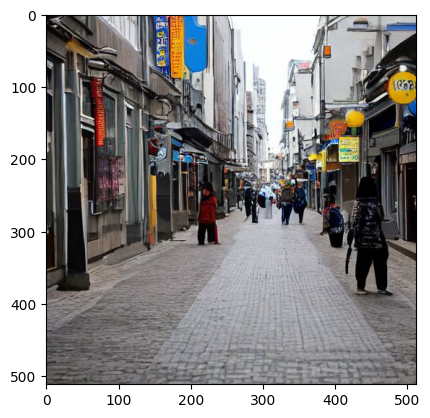

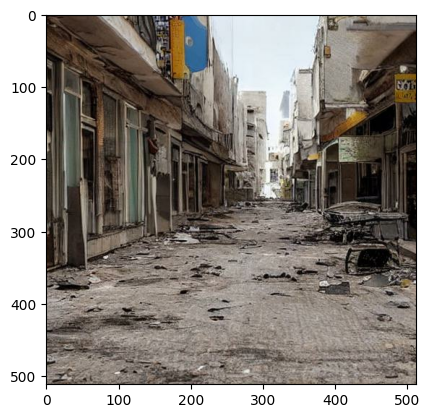

In [13]:
inp, re = load(PATH+ '/img_base/img_base_100021.jpg', str(PATH+ '/img_mod/img_mod_100021.jpg'))

# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [14]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

# Define preprocessing functions: resize, random_crop and normalize. 
Each training image will get resized, cropped back and randomly mirrored

In [15]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [16]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [17]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [18]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 572x572
  input_image, real_image = resize(input_image, real_image, 572, 572)

  # Random cropping back to 512x512
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

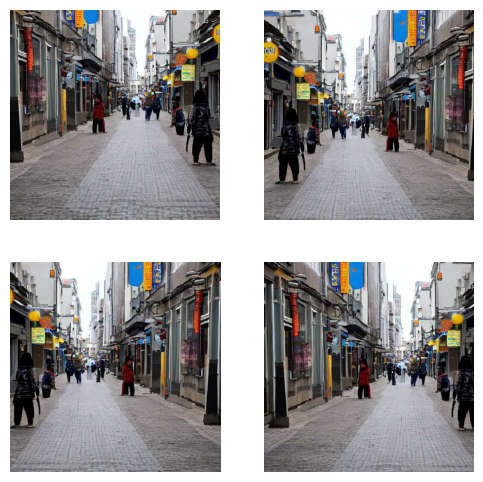

In [19]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

functions for loading the train/test sets



In [20]:
def load_image_train(input, output):
  input_image, real_image = load(input,output)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [21]:
def load_image_test(input, output):
  input_image, real_image = load(input,output)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline

In [22]:


img_paths = natsorted(glob(PATH + '/img_base/img_base_*.jpg'))

mask_paths = [ip.replace("base","mod") for ip in img_paths]

input_file_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
output_file_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)


# Create a dataset containing pairs ot and output file paths
train_dataset = tf.data.Dataset.zip((input_file_dataset, output_file_dataset))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)


train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)



In [23]:
try:

  #testset
  testset = natsorted(glob(PATH + '/testset/img_base/*.jpg'))
  mask_paths = [ip.replace("base","mod") for ip in testset]

  input_file_dataset = tf.data.Dataset.from_tensor_slices(testset)
  output_file_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)

  # Create a dataset containing pairs of input and output file paths
  test_dataset = tf.data.Dataset.zip((input_file_dataset, output_file_dataset))

except tf.errors.InvalidArgumentError:
  exit()

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Construct the Generator

The generator is essentially a tailored version of the [U-Net](https://arxiv.org/abs/1505.04597), composed of two main components: an encoder which downsamples, and a decoder which upsamples.

* Every module within the encoder follows the sequence: Convolution, then Batch 
normalization, and finally Leaky ReLU.

* Each unit within the decoder is structured as: Transposed convolution, followed by Batch normalization, with Dropout applied to the initial three blocks, and concluding with ReLU.

* As in the original U-Net architecture, there are skip connections bridging the encoder and the decoder.

Define the downsampler (encoder):

In [24]:
OUTPUT_CHANNELS = 3

In [25]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [26]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Define the generator with the downsampler and the upsampler:

In [27]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), 
    downsample(128, 4),  
    downsample(256, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4),  
    upsample(256, 4),  
    upsample(128, 4), 
    upsample(64, 4),  # (batch_size, 64, 64, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
generator = Generator()

## Establish the Generator's Loss Function

As outlined in the [pix2pix paper](https://arxiv.org/abs/1611.07004), cGANs are trained using a structured loss function. This loss function imposes penalties whenever there is a deviation between the network's output and the target image, thus ensuring the preservation of specific structural elements during the learning process.


In [29]:
LAMBDA = 100

In [30]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Construct the Discriminator

In the pix2pix cGAN architecture, the discriminator is designed as a convolutional PatchGAN classifier. This classifier's task is to ascertain the authenticity of each image patch—whether it's genuine or fabricated—as delineated in the [pix2pix paper](https://arxiv.org/abs/1611.07004).


We define the discriminator:

In [32]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 512, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  down4 = downsample(512, 4)(down3)  # (batch_size, 16, 16, 512)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 34, 34, 512)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [33]:
discriminator = Discriminator()

## Specify the Discriminator's Loss Function

* The `discriminator_loss` function requires two inputs: real images and generated images.
* `real_loss` calculates the sigmoid cross-entropy loss between the real images and an array of ones (corresponding to the label of real images).
* `generated_loss` computes the sigmoid cross-entropy loss between the generated images and an array of zeros (denoting the label of fake images).
* The `total_loss` is the cumulative sum of real_loss and generated_loss.

These principles are taken from  the [pix2pix paper](https://arxiv.org/abs/1611.07004).

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_dir = PATH_cp
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images


In [37]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Prompt2Prompt', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [38]:
# second generate)images function which is defined for real_life photos where now reference P2P output is known.

def generate_images_real_life(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(10, 10))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Training Process

Adopting the approach in the [pix2pix paper](https://arxiv.org/abs/1611.07004), the training sequence is as follows:

* An output is generated for each example input.
* The discriminator is provided with two inputs. The first input comprises of the input_image and the image generated by the generator. The second input consists of the input_image and the target_image.
* Subsequently, the loss for both the generator and the discriminator is computed.
* After this, the gradients of these losses with respect to the variables(inputs) of both the generator and the discriminator are calculated and applied to the optimizer.
* Lastly, these losses are logged for potential future analysis using TensorBoard.

In [39]:
log_dir=PATH_log

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

## The actual training loop. 

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      #generate_images(generator, example_input, example_target)
      for inp, tar in test_ds.take(10):
        generate_images(generator, inp, tar)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

## Tensorboard
To track the loss during and after training you can use [tensorboard](https://github.com/tensorflow/tensorboard).

in the conole run: 
`tensorboard --logdir "/PATH_log/"`



## Now the actual training

In [ ]:
# optionally restore checkpoint to resume training:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# main train loop
fit(train_dataset, test_dataset, steps=100_000)

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(50):
  generate_images(generator, inp, tar)